In [7]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.signal import find_peaks
import pandas as pd
import random

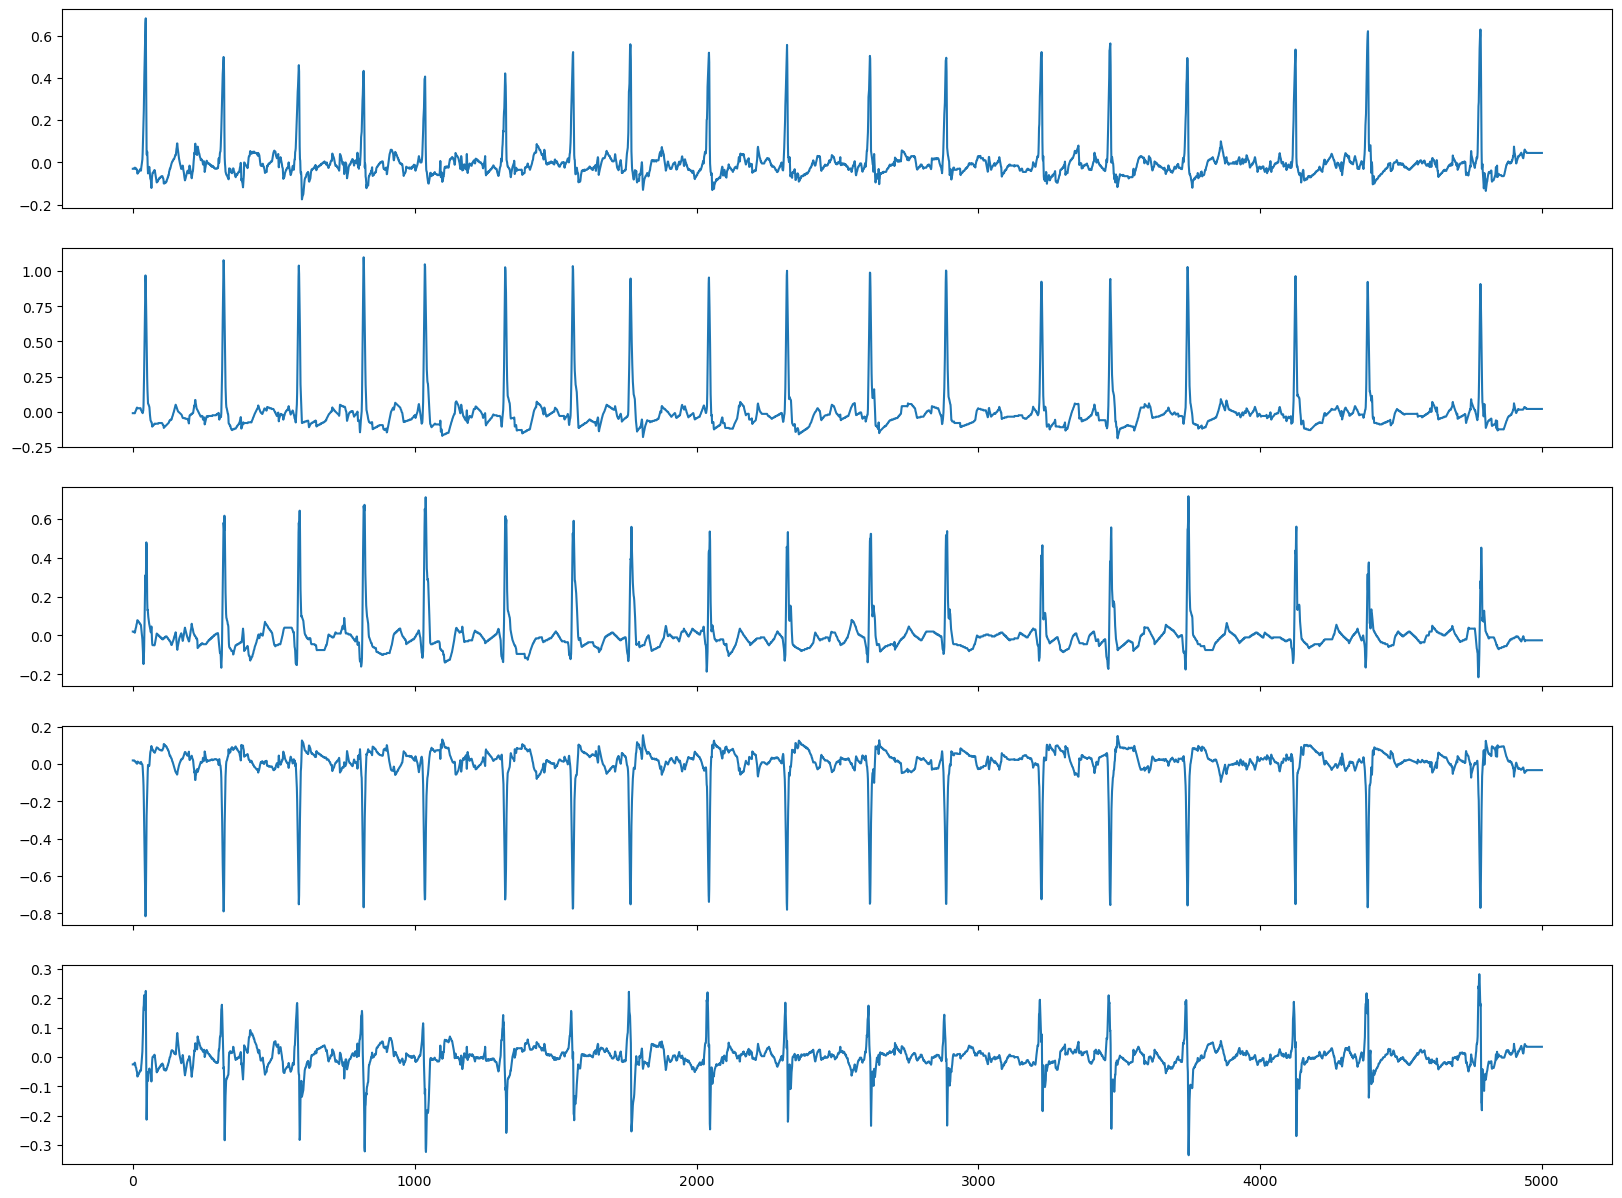

In [8]:
df = pd.read_csv('ptbxl-atrial-fibrillation-detection/coorteeqsrafva.csv', sep=';', header=0, index_col=0)
ecgeq_arr = np.load('ptbxl-atrial-fibrillation-detection/ecgeq-500hzsrfava.npy')




afib_df = df.copy()

# drop columns
afib_df = afib_df.drop(columns=['ecg_id', 'patient_id', 'nurse', 'site', 'device', 'report', 'scp_codes', 'infarction_stadium1', 'infarction_stadium2', 'validated_by', 'second_opinion', 'initial_autogenerated_report', 'baseline_drift', 'static_noise', 'burst_noise', 'electrodes_problems', 'extra_beats', 'pacemaker', 'filename_lr', 'filename_hr'])

afib_cases = list(afib_df[afib_df['ritmi']=='AF'].index)
normalcases = list(afib_df[afib_df['ritmi']=='SR'].index)


fig,ax = plt.subplots(5,1,figsize=(20,15),sharex=True,sharey=False)

for i in range(5):
    ax[i].plot(ecgeq_arr[afib_cases[1],:,i])

In [9]:
def peakDetect(signal, sampling_rate):
    r_peaks, _ = find_peaks(signal, distance=int(180), height=0.1) # Min distance between peaks


    rr_intervals = np.diff(r_peaks) / sampling_rate
    return rr_intervals, r_peaks

In [10]:
class AtrialFibrillationDetector:

    def __init__(self, rr_intervals, rr_position):
        if rr_intervals is None or len(rr_intervals) == 0:
            self.af_detected = 0  # Definindo a detecção como 0 se não houver intervalos R-R
        else:
            self.rr_intervals = rr_intervals
            self.rr_position = rr_position
            self.af_detected = None  # A detecção é indefinida inicialmente

    def detect_af(self, alpha, avg_th, overall_th):
        # Se os rr_intervals estiverem vazios, a detecção é 0
        if self.af_detected == 0:
            return self.af_detected
        
        # Normaliza os intervalos R-R pela sua média
        mean_rr = sum(self.rr_intervals) / len(self.rr_intervals)
        rr_normalized = [rr / mean_rr for rr in self.rr_intervals]
        
        # Detecta desvios além de 20% da média
        af_detection = [1.0 if abs(1 - rr) > avg_th else 0.0 for rr in rr_normalized]

        # Suaviza os valores de detecção usando um filtro passa-baixa
       
        smooth_af_detection = [af_detection[0]]
        for j in range(1, len(af_detection)):
            smoothed_value = alpha * af_detection[j] + (1 - alpha) * smooth_af_detection[j - 1]
            smooth_af_detection.append(smoothed_value)

        # Define um limite de suavização e conta as ocorrências
        
        af_detected = int(sum(1 for val in smooth_af_detection if val > overall_th) >= 5)
        
        # Armazena e retorna o resultado
        self.af_detected = af_detected
        return self.af_detected


In [12]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

# Definindo os intervalos para os parâmetros
alpha_values = np.linspace(0.05, 0.3, 3)  # 3 valores de alpha
avg_th_values = np.linspace(0.05, 0.30, 5)  # 5 valores de avg_th
overall_th_values = np.linspace(0.2, 0.8, 6)  # 6 valores de overall_th

# Função para realizar a otimização e calcular a precisão
def optimize_parameters(afib_cases, normalcases, ecgeq_arr):
    # Matriz para armazenar as precisões
    accuracy_matrix = np.zeros((len(alpha_values), len(avg_th_values), len(overall_th_values)))

    # Loop sobre todas as combinações possíveis dos parâmetros
    for i, alpha in enumerate(alpha_values):
        for j, avg_th in enumerate(avg_th_values):
            for k, overall_th in enumerate(overall_th_values):
                AF = []
                false_AF = []

                # Realizando a detecção de AF para os casos de fibrilação atrial (AF)
                for j_case in range(len(afib_cases)):
                    for i_case in range(12):
                        rr_intervals, r_peaks = peakDetect(ecgeq_arr[afib_cases[j_case], :, i_case], 5000)
                        detector = AtrialFibrillationDetector(rr_intervals, r_peaks)
                        AF.append(detector.detect_af(alpha, avg_th, overall_th))  # Detecção para AF

                # Realizando a detecção de AF para os casos normais
                for j_case in range(len(normalcases)):
                    for i_case in range(12):
                        rr_intervals, r_peaks = peakDetect(ecgeq_arr[normalcases[j_case], :, i_case], 5000)
                        detector = AtrialFibrillationDetector(rr_intervals, r_peaks)
                        false_AF.append(detector.detect_af(alpha, avg_th, overall_th))  # Detecção para casos normais
                
                # Calcular a precisão para a combinação atual dos parâmetros
                TP = AF.count(1)
                FN = AF.count(0)
                FP = false_AF.count(1)
                TN = false_AF.count(0)
                accuracy = (TP + TN) / (TP + FP + TN + FN)
                
                # Armazenar a precisão na matriz
                accuracy_matrix[i, j, k] = accuracy

    return accuracy_matrix, alpha_values, avg_th_values, overall_th_values

# Realizar otimização
accuracy_matrix, alpha_values, avg_th_values, overall_th_values = optimize_parameters(afib_cases, normalcases, ecgeq_arr)

# Encontrar o índice da precisão máxima
max_accuracy = np.max(accuracy_matrix)
max_index = np.unravel_index(np.argmax(accuracy_matrix), accuracy_matrix.shape)

# Recuperar os valores dos parâmetros para a precisão máxima
optimal_alpha = alpha_values[max_index[0]]
optimal_avg_th = avg_th_values[max_index[1]]
optimal_overall_th = overall_th_values[max_index[2]]

# Exibir os valores dos parâmetros para a precisão máxima
print(f"Valores ótimos de parâmetros para a maior precisão ({max_accuracy}):")
print(f"Alpha: {optimal_alpha}")
print(f"avg_th: {optimal_avg_th}")
print(f"overall_th: {optimal_overall_th}")



Valores ótimos de parâmetros para a maior precisão (0.761011987733482):
Alpha: 0.3
avg_th: 0.1125
overall_th: 0.44000000000000006


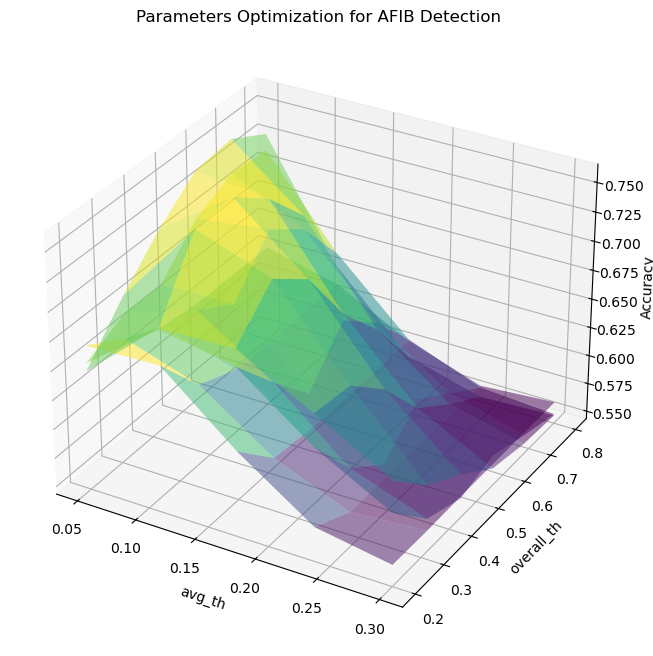

In [13]:
X, Y = np.meshgrid(avg_th_values, overall_th_values)

# Criar a figura e o gráfico 3D
fig = plt.figure(figsize=(10, 8))
ax = fig.add_subplot(111, projection='3d')

# Plotar superfícies para cada valor de alpha
for i, alpha in enumerate(alpha_values):
    Z = accuracy_matrix[i, :, :].T  # Transpor Z para alinhar com (6, 5)
    if Z.shape == X.shape:
        ax.plot_surface(X, Y, Z, cmap='viridis', alpha=0.5, label=f'Alpha = {alpha:.2f}')
    else:
        print(f"Erro: forma de Z {Z.shape} não corresponde a X {X.shape}.")

# Labels e título
ax.set_xlabel('avg_th')
ax.set_ylabel('overall_th')
ax.set_zlabel('Accuracy')
ax.set_title('Parameters Optimization for AFIB Detection')

# Mostrar o gráfico
plt.show()

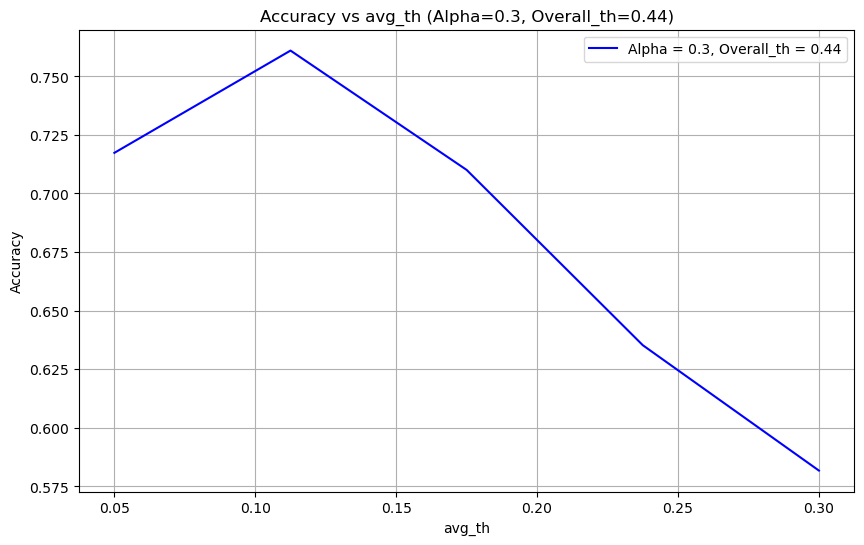

In [16]:
alpha_target = 0.3
overall_th_target = 0.44
alpha_index = np.argmin(np.abs(alpha_values - alpha_target))
overall_th_index = np.argmin(np.abs(overall_th_values - overall_th_target))

# Selecionar os dados de precisão para o alpha e overall_th fixados
accuracy_fixed = accuracy_matrix[alpha_index, :, overall_th_index]

# Plotar o gráfico 2D
plt.figure(figsize=(10, 6))
plt.plot(avg_th_values, accuracy_fixed, linestyle='-', color='b', label=f'Alpha = {alpha_target}, Overall_th = {overall_th_target:.2f}')

# Configurar o gráfico
plt.xlabel('avg_th')
plt.ylabel('Accuracy')
plt.title('Accuracy vs avg_th (Alpha=0.3, Overall_th=0.44)')
plt.grid(True)
plt.legend()
plt.show()

In [17]:
AF= []
false_AF=[]
for j in range(len(afib_cases)):
    for i in range(12):
        rr_intervals, r_peaks = peakDetect(ecgeq_arr[afib_cases[j],:,i],5000)
        detector = AtrialFibrillationDetector(rr_intervals, r_peaks)
        
        # Realize a detecção de AF
        AF.append(detector.detect_af(0.3,0.1125,0.44))  # Armazena o resultado no array AF

for j in range(len(afib_cases)):
    for i in range(12):
        rr_intervals, r_peaks = peakDetect(ecgeq_arr[normalcases[j],:,i],5000)
        detector = AtrialFibrillationDetector(rr_intervals, r_peaks)

        # Realize a detecção de AF
        false_AF.append(detector.detect_af(0.3,0.1125,0.44))  # Armazena o resultado no array AF

TP = AF.count(1)
FN = AF.count(0)
FP = false_AF.count(1)
TN = false_AF.count(0)
accuracy = (TP + TN) / (TP + FP + TN + FN)        
precision= TP/(TP+FP)
recall = TP/(TP+FN)

print(TP)
print(FP)
print(TN)
print(FN)
print(f'Acc: {accuracy}')

print(f'Pre: {precision}')
print(f'Re: {recall}')

15946
5683
13361
3098
Acc: 0.7694549464398236
Pre: 0.7372509131258957
Re: 0.8373240915773997


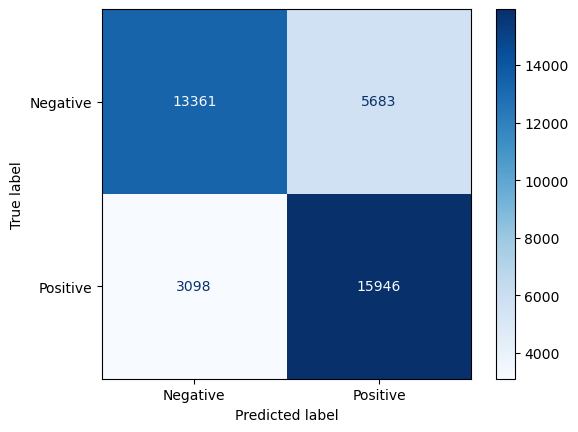

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# Dados reais e previstos
y_true = np.ones(len(AF))
y_true = np.append(y_true, np.zeros(len(false_AF)))

y_pred = np.append(AF,false_AF)

# Criando a matriz de confusão
cm = confusion_matrix(y_true, y_pred)

# Exibindo a matriz de confusão
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=["Negative", "Positive"])
disp.plot(cmap="Blues")
